<a href="https://colab.research.google.com/github/SytzeSimonse/DeepLearning_MGI/blob/master/MGIprojectv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
### Import data

import os
import zipfile

# remove folder to avoid error thrown
! rm -rf ucmdata

! git clone https://git.wur.nl/lobry001/ucmdata.git
os.chdir('ucmdata')

with zipfile.ZipFile('UCMerced_LandUse.zip', 'r') as zip_ref:
    zip_ref.extractall('UCMImages')

!mv UCMImages/UCMerced_LandUse/Images .
!rm -rf UCMImages README.md  UCMerced_LandUse.zip
!ls

UCM_images_path = "Images/"
Multilabels_path = "LandUse_Multilabeled.txt"

os.listdir(UCM_images_path)

Cloning into 'ucmdata'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 8 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (8/8), done.
Images	LandUse_Multilabeled.txt


['harbor',
 'freeway',
 'mobilehomepark',
 'airplane',
 'river',
 'intersection',
 'beach',
 'chaparral',
 'storagetanks',
 'golfcourse',
 'sparseresidential',
 'runway',
 'tenniscourt',
 'mediumresidential',
 'forest',
 'parkinglot',
 'denseresidential',
 'agricultural',
 'baseballdiamond',
 'overpass',
 'buildings']

In [0]:
# install packages
! pip install mxnet --pre -q # mxnet
! pip install git+https://github.com/d2l-ai/d2l-en # d2l

# importing libraries
from mxnet import gluon, image, gpu, init, autograd, npx, ndarray
from mxnet.gluon import nn
import time
import d2l
import numpy as np
from shutil import rmtree
import mxnet as mx
from PIL import Image
%matplotlib inline

  Cloning https://github.com/d2l-ai/d2l-en to /tmp/pip-req-build-at4s7_hc
  Running command git clone -q https://github.com/d2l-ai/d2l-en /tmp/pip-req-build-at4s7_hc
  Created wheel for d2l: filename=d2l-0.11.4-cp36-none-any.whl size=31941 sha256=9b672c6fe98452d06de595e65c6e0bf568e5f10f4db012f4165850b923cdef11
  Stored in directory: /tmp/pip-ephem-wheel-cache-2p_k9dzb/wheels/82/6f/b8/8422c7ed664272685e3d139b127f89df39d934704a14b2156c
Successfully built d2l


In [0]:
# prepare data folders for single-label classification

# prepare and split the data

# split percentages
train = 60
test = 20
val = 20

# Make folders for the split data 
destFolder = 'preparedData/'
trainFolder = destFolder+'train/'
testFolder = destFolder+'test/'
valFolder = destFolder+'val/'

if os.path.isdir(destFolder):
  rmtree(destFolder)

os.mkdir(destFolder)
os.mkdir(trainFolder)
os.mkdir(testFolder)
os.mkdir(valFolder)

# get the class labels and loop over their folders
labels = os.listdir(UCM_images_path)
for l in labels:
  imgs = os.listdir(UCM_images_path+l)

  # Make the destination folders
  if not os.path.isdir(trainFolder + l):
    os.mkdir(trainFolder + l)
  if not os.path.isdir(testFolder + l):
    os.mkdir(testFolder + l)
  if not os.path.isdir(valFolder + l):
    os.mkdir(valFolder + l)

  #generate the numbers 0-99 in random order
  split = np.arange(100)
  np.random.shuffle(split)

  # copy images to train data folder and convert to jpeg
  for i in range(train):
    imgno = np.char.zfill(str(split[i]),2)
    im = Image.open(UCM_images_path + l +'/' + l + str(imgno) + '.tif')
    im.save(trainFolder + l +'/' + l + str(imgno) + '.jpeg')
  
  # copy images to test data folder and convert to jpeg
  for i in range(test):
    imgno = np.char.zfill(str(split[i+train]),2)
    im = Image.open(UCM_images_path + l +'/' + l + str(imgno) + '.tif')
    im.save(testFolder + l +'/' + l + str(imgno) + '.jpeg')
  
  # copy images to validation data folder and convert to jpeg
  for i in range(val):
    imgno = np.char.zfill(str(split[i+train+test]),2)
    im = Image.open(UCM_images_path + l +'/' + l + str(imgno) + '.tif')
    im.save(valFolder + l +'/' + l + str(imgno) + '.jpeg')

train_dataset = mx.gluon.data.vision.datasets.ImageFolderDataset(trainFolder)
test_dataset = mx.gluon.data.vision.datasets.ImageFolderDataset(testFolder)
val_dataset = mx.gluon.data.vision.datasets.ImageFolderDataset(valFolder)

In [0]:
# get header (i.e. classes) from multilabel txt file
with open(Multilabels_path, 'r') as f:
    f_line = f.readline()
    multi_classes = f_line.split()
    
del multi_classes[0] # remove "IMAGE\LABEL"

# get first column, with filenames, from .txt
filenames = np.loadtxt(Multilabels_path, dtype = str, usecols = 0, skiprows = 1) 

# function to remove first row and column from data
def extract_data(fname, delimiter = None):
    with open(fname, 'r') as fin:
        next(fin)
        for line in fin:
            try:
               yield line.split(delimiter, 1)[1]
            except IndexError:
               continue

# get data from .txt file
data = np.loadtxt(extract_data(Multilabels_path))

# Function to get multilabel class values for filename
## filename [str]: filename to get class values for
## selected_class [str]: label to get value for (optional, default: all labels)
def get_class_values(filename, selected_class = None):
  idx, = np.where(filenames == filename)
  if selected_class is not None:
    class_idx = multi_classes.index(selected_class)
    return data[idx[0]][class_idx]
  try:
    return mx.nd.array(data[idx[0]]).astype('float32')
  except:
    print("Something went wrong when parsing the data.")
    return False

# example: Does 'agricultural00' contain trees?
get_class_values("agricultural00", "trees") # yes!

1.0

In [0]:
import copy

def single_to_multi(dataset):
  # copy dataset
  multi_dataset = copy.deepcopy(dataset)

  # create list for updated dataset items
  updated_items = []

  # var for dataset items
  items = dataset.items

  # loop through all items (i.e. images)
  for item in items:
    # get filepath of image
    fpath = item[0]

    # remove trail of filepath (only get e.g. 'agricultural00')
    fname = os.path.basename(os.path.normpath(fpath))
    fname = os.path.splitext(fname)[0] # remove extension (.jpeg)

    # create tuple of fpath and classes vector (to keep same format)
    new_item = (fpath, get_class_values(fname))

    # add tuple to list of updated items
    updated_items.append(new_item)

  multi_dataset.items = updated_items
  return multi_dataset

train_dataset_multilabel = single_to_multi(train_dataset)
val_dataset_multilabel = single_to_multi(val_dataset)
test_dataset_multilabel = single_to_multi(test_dataset)

In [0]:
### SINGLE-LABEL CLASSIFICATION ###

# Function to train single batch
def train_batch(net, features, labels, loss, trainer, ctx_list, split_f=d2l.split_batch):
    X_shards, y_shards = split_f(features, labels, ctx_list)
    with autograd.record():
      pred_shards = [net(X_shard) for X_shard in X_shards]
      ls = [loss(pred_shard, y_shard) for pred_shard, y_shard
            in zip(pred_shards, y_shards)]
    for l in ls:
        l.backward()

    trainer.step(labels.shape[0], ignore_stale_grad=True)
    train_loss_sum = sum([l.sum() for l in ls]) 
    train_acc_sum = sum(accuracy(pred_shard, y_shard) for pred_shard, y_shard in zip(pred_shards, y_shards))
    return train_loss_sum, train_acc_sum
 
# Function to calculate accuracy per batch
def accuracy(y_hat, y):
    if y_hat.shape[1] > 1:
        return (y_hat.argmax(axis=1).astype('float32') == y.astype('float32')).sum()
    else:
        print("Result: ", float((y_hat.astype('int32') == y.astype('int32')).sum()))
        return float((y_hat.astype('int32') == y.astype('int32')).sum())

# Function to evaluate accuracy on test data
def evaluate_accuracy(net, data_iter):
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        acc = accuracy(net(X), y)
        metric.add(acc.asscalar(), y.size)
    return metric[0]/metric[1]

# Function to train network and plot results
def train(net, train_iter, test_iter, loss, trainer, num_epochs,
               ctx_list=d2l.try_all_gpus(), split_f=d2l.split_batch):
    num_batches, timer = len(train_iter), d2l.Timer()
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = train_batch(
                net, features, labels, loss, trainer, ctx_list, split_f)
            metric.add(l.asscalar(), acc.asscalar(), labels.shape[0], labels.size)
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0:
                animator.add(epoch + i / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print('loss %.3f, train acc %.3f, test acc %.3f' % (
        metric[0] / metric[2], metric[1] / metric[3], test_acc))
    print('%.1f examples/sec on %s' % (
        metric[2] * num_epochs / timer.sum(), ctx_list))

# Function to finetune pre-trained network
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5):
    train_iter = gluon.data.DataLoader(train_dataset.transform_first(train_augs), batch_size, shuffle=True)
    test_iter = gluon.data.DataLoader(test_dataset.transform_first(test_augs), batch_size)
    ctx = d2l.try_all_gpus()
    net.collect_params().reset_ctx(ctx)
    net.hybridize()
    loss = gluon.loss.SoftmaxCrossEntropyLoss()
    trainer = gluon.Trainer(net.collect_params(), 'sgd', {
        'learning_rate': learning_rate, 'wd': 0.001})
    timer = d2l.Timer()
    timer.start()
    train(net, train_iter, test_iter, loss, trainer, num_epochs)
    ### finally: get accuracy of validation set
    val_iter = gluon.data.DataLoader(val_dataset.transform_first(test_augs), batch_size)
    val_acc = evaluate_accuracy(net, val_iter)
    timer.stop()
    print('validation accuracy:'+ str(round(val_acc,3)) + ', time taken: ' + str(round(timer.sum(),1)))


In [0]:
### MULTI-LABEL CLASSIFICATION ###
from math import e

def sigmoid_activation(pred_shard, threshold):
  outputs = []
  for pred in pred_shard:
    activation = 1 / (1 + e ** pred)
    output = []
    for prob in activation:
      output.append(0 if prob > threshold else 1)
    outputs.append(output)
  return ndarray.array(outputs)

# metric functions
def precision(y_pred, y_true):
  # pass through sigmoid
  y_pred = sigmoid_activation(y_pred, 0.8)
  output = []
  for i in range(len(y_pred)):
    intersect = sum(y_pred[i] + y_true[i] - 2 == 0)
    output.append(intersect / sum(y_pred[i]).astype("float32"))
  return(max(output))

# calculate recall
def recall(y_pred, y_true):
  intersect = sum(y_pred + y_true - 2 == 0)
  return (intersect / sum(y_true)).astype("float32")

# calculate f-score
def f_score(precision, recall):
  return 2 * ((precision * recall) / (precision + recall))

def train_batch_ch13_multilabel(net, features, labels, loss, trainer, ctx_list, split_f=d2l.split_batch):
    X_shards, y_shards = split_f(features, labels, ctx_list)

    with autograd.record():
      pred_shards = [net(X_shard) for X_shard in X_shards]
      ls = [loss(pred_shard, y_shard) for pred_shard, y_shard in zip(pred_shards, y_shards)]
    for l in ls:
      l.backward()

    trainer.step(labels.shape[0], ignore_stale_grad=True)
    train_loss_sum = sum([l.sum() for l in ls]) 

    # compute metrics, for all shards!
    train_precision_sum = sum(precision(pred_shard, y_shard) for pred_shard, y_shard in zip(pred_shards, y_shards))

    return train_loss_sum, train_precision_sum

def train_ch13_multilabel(net, train_iter, test_iter, loss, trainer, num_epochs,
               ctx_list=d2l.try_all_gpus(), split_f=d2l.split_batch):
    num_batches, timer = len(train_iter), d2l.Timer()
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'precision'])

    for epoch in range(num_epochs):
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            train_batch_ch13_multilabel(net, features, labels, loss, trainer, ctx_list, split_f)

            l, precision = train_batch_ch13_multilabel(
                net, features, labels, loss, trainer, ctx_list, split_f)

            metric.add(l.asscalar(), precision.asscalar(), labels.shape[0], labels.size)
            timer.stop()

            if (i + 1) % (num_batches // 5) == 0:
              animator.add(epoch + i / num_batches, (metric[0] / metric[2], metric[1], None))
    print('loss %.3f, train acc %.3f' % (
        metric[0] / metric[2], metric[1] / metric[3]))
    print('%.1f examples/sec on %s' % (
        metric[2] * num_epochs / timer.sum(), ctx_list))

def train_fine_tuning_multilabel(net, learning_rate, batch_size = 64, num_epochs = 1):
    train_iter = gluon.data.DataLoader(train_dataset_multilabel.transform_first(train_augs), batch_size, shuffle=True)
    test_iter = gluon.data.DataLoader(test_dataset_multilabel.transform_first(test_augs), batch_size)
    ctx = d2l.try_all_gpus()
    net.collect_params().reset_ctx(ctx)
    net.hybridize()

    loss = gluon.loss.SigmoidBCELoss()

    trainer = gluon.Trainer(net.collect_params(), 'sgd', {
        'learning_rate': learning_rate, 'wd': 0.001})
    
    timer = d2l.Timer()
    timer.start()

    train_ch13_multilabel(net, train_iter, test_iter, loss, trainer, num_epochs)

In [0]:
### DATA AUGMENTATION ###

# training data
train_augs = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.RandomResizedCrop(224), # random resize crop to 224x224

    gluon.data.vision.transforms.RandomFlipLeftRight(), # flip horizontally
    gluon.data.vision.transforms.RandomFlipTopBottom(), # flip vertically

    gluon.data.vision.transforms.ToTensor()])

# test data
test_augs = gluon.data.vision.transforms.Compose([
    gluon.data.vision.transforms.Resize(256),

    gluon.data.vision.transforms.CenterCrop(224),

    gluon.data.vision.transforms.ToTensor()])

KeyboardInterrupt: ignored

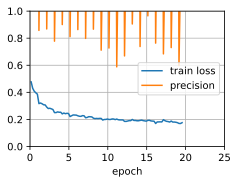

In [23]:
# Finetune a pretrained alexnet for multi-label classification

# load a pretrained alexnet
pretrained_alexnet  = gluon.model_zoo.vision.alexnet(pretrained=True) ## AlexNet ##

# create an alexnet with 21 outputs, put pretrained weights in and initialize the output layer. Also set the learn rate for the output layer 10x higher
finetune_net = gluon.model_zoo.vision.alexnet(classes=17)
finetune_net.features = pretrained_alexnet.features
finetune_net.output.initialize(init.Xavier())
finetune_net.output.collect_params().setattr('lr_mult', 10)

finetune_net.output
train_fine_tuning_multilabel(finetune_net, learning_rate = 0.005, batch_size = 64, num_epochs=25)

In [62]:
# Validating multi-label classification

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

val_iter = gluon.data.DataLoader(val_dataset_multilabel.transform_first(test_augs), 1, shuffle=True)

examples = 10
ex = 0

def activate(labels):
  for i in range(len(labels)):
    if labels[i] == 1:
      print(multi_classes[i])

for X, y in val_iter:
  #imgplot = plt.imshow(X)
  #plt.show()

  print("prediction:", sigmoid_activation(finetune_net(X), 0.99))
  print('expected outcome:', y)

  print("\n\n")

  ex +=1
  if ex >= examples:
    break



prediction: 
[[0. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0.]]
<NDArray 1x17 @cpu(0)>
expected outcome: 
[[0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0.]]
<NDArray 1x17 @cpu(0)>



prediction: 
[[0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1.]]
<NDArray 1x17 @cpu(0)>
expected outcome: 
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]]
<NDArray 1x17 @cpu(0)>



prediction: 
[[0. 1. 1. 1. 1. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 0.]]
<NDArray 1x17 @cpu(0)>
expected outcome: 
[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
<NDArray 1x17 @cpu(0)>



prediction: 
[[0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0.]]
<NDArray 1x17 @cpu(0)>
expected outcome: 
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
<NDArray 1x17 @cpu(0)>



prediction: 
[[0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]
<NDArray 1x17 @cpu(0)>
expected outcome: 
[[0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
<NDArray 1x17 @cpu(0)>



prediction: 
[[0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 

loss 0.435, train acc 0.858, test acc 0.879
11.2 examples/sec on [cpu(0)]
validation accuracy:0.905, time taken: 3588.0


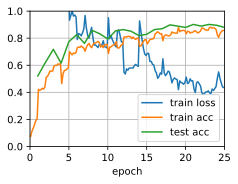

In [0]:
# Finetune a pretrained alexnet

# load a pretrained alexnet
pretrained_alexnet  = gluon.model_zoo.vision.alexnet(pretrained=True) ## AlexNet ##

# create an alexnet with 21 outputs, put pretrained weights in and initialize the output layer. Also set the learn rate for the output layer 10x higher
finetune_net = gluon.model_zoo.vision.alexnet(classes=21)
finetune_net.features = pretrained_alexnet.features
finetune_net.output.initialize(init.Xavier())
finetune_net.output.collect_params().setattr('lr_mult', 10)

finetune_net.output
train_fine_tuning(finetune_net, 0.01, num_epochs=25)

loss 0.145, train acc 0.961, test acc 0.638
3.7 examples/sec on [cpu(0)]
validation accuracy:0.689, time taken: 10845.4


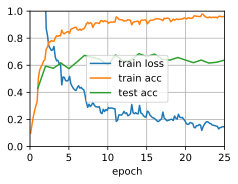

In [0]:
# Finetune a pretrained resnet

# load a pretrained resnet
pretrained_resnet = gluon.model_zoo.vision.resnet18_v2(pretrained=True)

# create a resnet with 21 outputs, put pretrained weights in and initialize the output layer
finetune_net = gluon.model_zoo.vision.resnet18_v2(classes=21)
finetune_net.features = pretrained_resnet.features
finetune_net.output.initialize(init.Xavier())
finetune_net.output.collect_params().setattr('lr_mult', 10)

finetune_net.output
train_fine_tuning(finetune_net, 0.01, num_epochs=25)

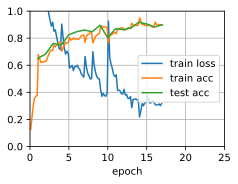

In [0]:
# Finetune a pretrained cifar_resnet

# load a pretrained resnet
pretrained_resnet = gluon.model_zoo.vision.vgg11(pretrained=True)

# create a resnet with 21 outputs, put pretrained weights in and initialize the output layer
finetune_net = gluon.model_zoo.vision.vgg11(classes=21)
finetune_net.features = pretrained_resnet.features
finetune_net.output.initialize(init.Xavier())
finetune_net.output.collect_params().setattr('lr_mult', 10)

finetune_net.output
train_fine_tuning(finetune_net, 0.01, num_epochs=25)



loss 0.450, train acc 0.854, test acc 0.908
12.3 examples/sec on [cpu(0)]
validation accuracy:0.914, time taken: 3281.4


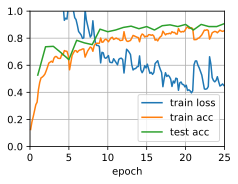

In [0]:
# Learn rate 0.005 

# load a pretrained alexnet
pretrained_alexnet  = gluon.model_zoo.vision.alexnet(pretrained=True) ## AlexNet ##

# create an alexnet with 21 outputs, put pretrained weights in and initialize the output layer. Also set the learn rate for the output layer 10x higher
finetune_net = gluon.model_zoo.vision.alexnet(classes=21)
finetune_net.features = pretrained_alexnet.features
finetune_net.output.initialize(init.Xavier())
finetune_net.output.collect_params().setattr('lr_mult', 10)

finetune_net.output
train_fine_tuning(finetune_net, 0.005, num_epochs=25)

loss 0.528, train acc 0.820, test acc 0.895
10.9 examples/sec on [cpu(0)]
validation accuracy:0.895, time taken: 3696.3


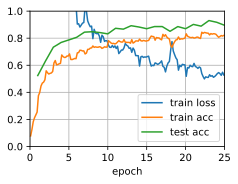

In [0]:
# Learn rate 0.0025 

# load a pretrained alexnet
pretrained_alexnet  = gluon.model_zoo.vision.alexnet(pretrained=True) ## AlexNet ##

# create an alexnet with 21 outputs, put pretrained weights in and initialize the output layer. Also set the learn rate for the output layer 10x higher
finetune_net = gluon.model_zoo.vision.alexnet(classes=21)
finetune_net.features = pretrained_alexnet.features
finetune_net.output.initialize(init.Xavier())
finetune_net.output.collect_params().setattr('lr_mult', 10)

finetune_net.output
train_fine_tuning(finetune_net, 0.0025, num_epochs=25)

loss 3.046, train acc 0.050, test acc 0.111
11.6 examples/sec on [cpu(0)]
validation accuracy:0.098, time taken: 3472.6


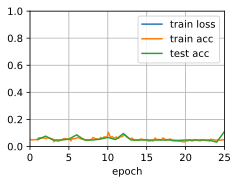

In [0]:
# Learn rate 0.02 

# load a pretrained alexnet
pretrained_alexnet  = gluon.model_zoo.vision.alexnet(pretrained=True) ## AlexNet ##

# create an alexnet with 21 outputs, put pretrained weights in and initialize the output layer. Also set the learn rate for the output layer 10x higher
finetune_net = gluon.model_zoo.vision.alexnet(classes=21)
finetune_net.features = pretrained_alexnet.features
finetune_net.output.initialize(init.Xavier())
finetune_net.output.collect_params().setattr('lr_mult', 10)

finetune_net.output
train_fine_tuning(finetune_net, 0.02, num_epochs=25)

loss 0.503, train acc 0.844, test acc 0.898
11.6 examples/sec on [cpu(0)]
validation accuracy:0.905, time taken: 3485.6


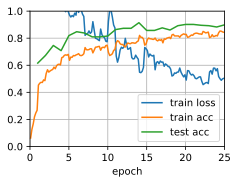

In [0]:
# Learn rate multiplier 5

# load a pretrained alexnet
pretrained_alexnet  = gluon.model_zoo.vision.alexnet(pretrained=True) ## AlexNet ##

# create an alexnet with 21 outputs, put pretrained weights in and initialize the output layer. Also set the learn rate for the output layer 10x higher
finetune_net = gluon.model_zoo.vision.alexnet(classes=21)
finetune_net.features = pretrained_alexnet.features
finetune_net.output.initialize(init.Xavier())
finetune_net.output.collect_params().setattr('lr_mult', 5)

finetune_net.output
train_fine_tuning(finetune_net, 0.005, num_epochs=25)

loss 0.448, train acc 0.856, test acc 0.898
11.6 examples/sec on [cpu(0)]
validation accuracy:0.902, time taken: 3487.7


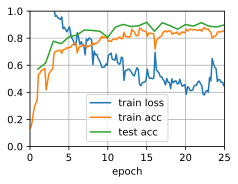

In [0]:
# Learn rate multiplier 20

# load a pretrained alexnet
pretrained_alexnet  = gluon.model_zoo.vision.alexnet(pretrained=True) ## AlexNet ##

# create an alexnet with 21 outputs, put pretrained weights in and initialize the output layer. Also set the learn rate for the output layer 10x higher
finetune_net = gluon.model_zoo.vision.alexnet(classes=21)
finetune_net.features = pretrained_alexnet.features
finetune_net.output.initialize(init.Xavier())
finetune_net.output.collect_params().setattr('lr_mult', 20)

finetune_net.output
train_fine_tuning(finetune_net, 0.005, num_epochs=25)

KeyboardInterrupt: ignored

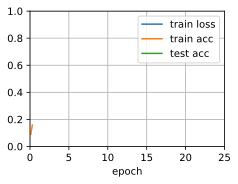

In [0]:
# Learn rate multiplier 15

# load a pretrained alexnet
pretrained_alexnet  = gluon.model_zoo.vision.alexnet(pretrained=True) ## AlexNet ##

# create an alexnet with 21 outputs, put pretrained weights in and initialize the output layer. Also set the learn rate for the output layer 10x higher
finetune_net = gluon.model_zoo.vision.alexnet(classes=21)
finetune_net.features = pretrained_alexnet.features
finetune_net.output.initialize(init.Xavier())
finetune_net.output.collect_params().setattr('lr_mult', 15)

finetune_net.output
train_fine_tuning(finetune_net, 0.005, num_epochs=25)

loss 0.382, train acc 0.874, test acc 0.914
10.9 examples/sec on [cpu(0)]
validation accuracy:0.93, time taken: 3703.9


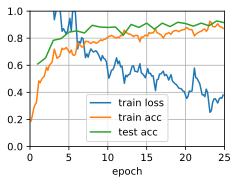

In [0]:
# batch size 64

# load a pretrained alexnet
pretrained_alexnet  = gluon.model_zoo.vision.alexnet(pretrained=True) ## AlexNet ##

# create an alexnet with 21 outputs, put pretrained weights in and initialize the output layer. Also set the learn rate for the output layer 10x higher
finetune_net = gluon.model_zoo.vision.alexnet(classes=21)
finetune_net.features = pretrained_alexnet.features
finetune_net.output.initialize(init.Xavier())
finetune_net.output.collect_params().setattr('lr_mult', 10)

finetune_net.output
train_fine_tuning(finetune_net, 0.005, batch_size = 64, num_epochs=25)

loss 0.353, train acc 0.882, test acc 0.943
10.0 examples/sec on [cpu(0)]
validation accuracy:0.917, time taken: 3998.2


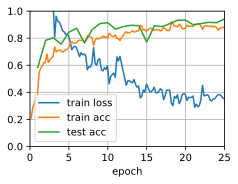

In [0]:
# batch size 32

# load a pretrained alexnet
pretrained_alexnet  = gluon.model_zoo.vision.alexnet(pretrained=True) ## AlexNet ##

# create an alexnet with 21 outputs, put pretrained weights in and initialize the output layer. Also set the learn rate for the output layer 10x higher
finetune_net = gluon.model_zoo.vision.alexnet(classes=21)
finetune_net.features = pretrained_alexnet.features
finetune_net.output.initialize(init.Xavier())
finetune_net.output.collect_params().setattr('lr_mult', 10)

finetune_net.output
train_fine_tuning(finetune_net, 0.005, batch_size = 32, num_epochs=25)

loss 0.538, train acc 0.818, test acc 0.886
12.3 examples/sec on [cpu(0)]
validation accuracy:0.87, time taken: 3286.6


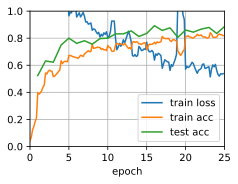

In [0]:
# batch size 256

# load a pretrained alexnet
pretrained_alexnet  = gluon.model_zoo.vision.alexnet(pretrained=True) ## AlexNet ##

# create an alexnet with 21 outputs, put pretrained weights in and initialize the output layer. Also set the learn rate for the output layer 10x higher
finetune_net = gluon.model_zoo.vision.alexnet(classes=21)
finetune_net.features = pretrained_alexnet.features
finetune_net.output.initialize(init.Xavier())
finetune_net.output.collect_params().setattr('lr_mult', 10)

finetune_net.output
train_fine_tuning(finetune_net, 0.005, batch_size = 256, num_epochs=25)

loss 0.418, train acc 0.867, test acc 0.938
11.2 examples/sec on [cpu(0)]
validation accuracy:0.919, time taken: 3994.9


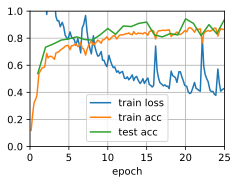

In [0]:
# split 80 - 10 - 10

# load a pretrained alexnet
pretrained_alexnet  = gluon.model_zoo.vision.alexnet(pretrained=True) ## AlexNet ##

# create an alexnet with 21 outputs, put pretrained weights in and initialize the output layer. Also set the learn rate for the output layer 10x higher
finetune_net = gluon.model_zoo.vision.alexnet(classes=21)
finetune_net.features = pretrained_alexnet.features
finetune_net.output.initialize(init.Xavier())
finetune_net.output.collect_params().setattr('lr_mult', 10)

#finetune_net.output
train_fine_tuning(finetune_net, 0.005, batch_size = 64, num_epochs=25)

loss 0.385, train acc 0.873, test acc 0.907
9.5 examples/sec on [cpu(0)]
validation accuracy:0.888, time taken: 3749.2


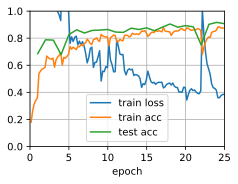

In [0]:
# split 60 - 20 - 20

# load a pretrained alexnet
pretrained_alexnet  = gluon.model_zoo.vision.alexnet(pretrained=True) ## AlexNet ##

# create an alexnet with 21 outputs, put pretrained weights in and initialize the output layer. Also set the learn rate for the output layer 10x higher
finetune_net = gluon.model_zoo.vision.alexnet(classes=21)
finetune_net.features = pretrained_alexnet.features
finetune_net.output.initialize(init.Xavier())
finetune_net.output.collect_params().setattr('lr_mult', 10)

#finetune_net.output
train_fine_tuning(finetune_net, 0.005, batch_size = 64, num_epochs=25)

loss 0.034, train acc 0.988, test acc 0.946
9.6 examples/sec on [cpu(0)]
validation accuracy:0.924, time taken: 4192.7


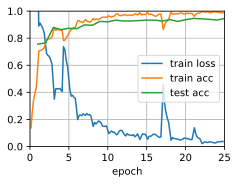

In [0]:
# no data augmentation

# load a pretrained alexnet
pretrained_alexnet  = gluon.model_zoo.vision.alexnet(pretrained=True) ## AlexNet ##

# create an alexnet with 21 outputs, put pretrained weights in and initialize the output layer. Also set the learn rate for the output layer 10x higher
finetune_net = gluon.model_zoo.vision.alexnet(classes=21)
finetune_net.features = pretrained_alexnet.features
finetune_net.output.initialize(init.Xavier())
finetune_net.output.collect_params().setattr('lr_mult', 10)

#finetune_net.output
train_fine_tuning(finetune_net, 0.005, batch_size = 64, num_epochs=25)

loss 0.405, train acc 0.866, test acc 0.949
10.7 examples/sec on [cpu(0)]
validation accuracy:0.933, time taken: 3757.9


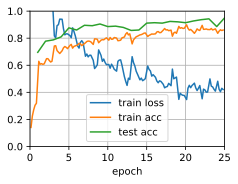

In [0]:
# data augmentation profile 3

# load a pretrained alexnet
pretrained_alexnet  = gluon.model_zoo.vision.alexnet(pretrained=True) ## AlexNet ##

# create an alexnet with 21 outputs, put pretrained weights in and initialize the output layer. Also set the learn rate for the output layer 10x higher
finetune_net = gluon.model_zoo.vision.alexnet(classes=21)
finetune_net.features = pretrained_alexnet.features
finetune_net.output.initialize(init.Xavier())
finetune_net.output.collect_params().setattr('lr_mult', 10)

#finetune_net.output
train_fine_tuning(finetune_net, 0.005, batch_size = 64, num_epochs=25)

loss 0.076, train acc 0.969, test acc 0.911
10.9 examples/sec on [cpu(0)]
validation accuracy:0.927, time taken: 3669.2


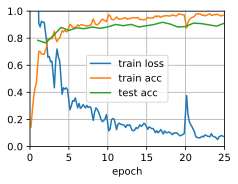

In [0]:
# data augmentation profile 2

# load a pretrained alexnet
pretrained_alexnet  = gluon.model_zoo.vision.alexnet(pretrained=True) ## AlexNet ##

# create an alexnet with 21 outputs, put pretrained weights in and initialize the output layer. Also set the learn rate for the output layer 10x higher
finetune_net = gluon.model_zoo.vision.alexnet(classes=21)
finetune_net.features = pretrained_alexnet.features
finetune_net.output.initialize(init.Xavier())
finetune_net.output.collect_params().setattr('lr_mult', 10)

#finetune_net.output
train_fine_tuning(finetune_net, 0.005, batch_size = 64, num_epochs=25)

In [25]:
val_iter = gluon.data.DataLoader(val_dataset.transform_first(test_augs), 1, shuffle=True)
examples = 10
ex = 0
for X, y in val_iter:
        print('prediction:')
        print(finetune_net(X))
        print('expected outcome:')
        print(sigmoid_activation(y, 0.9))
        ex +=1
        if ex >= examples:
          break
        


prediction:

[[ -6.496454    -0.94739455  -3.0025432   -3.2983336   -7.5982714
   -6.1405144   -9.972429    -4.6602836   -0.15681386 -10.154817
    0.21164311  -1.167484    -2.572052    -9.332002    -5.631785
   -1.2617003   -3.3196523 ]]
<NDArray 1x17 @cpu(0)>
expected outcome:

[[0.]]
<NDArray 1x1 @cpu(0)>
prediction:

[[-2.0116754 -4.6030855 -3.6157184 -2.7109528 -7.1884427 -5.231613
   3.571707  -4.9747    -2.0413513 -4.885618  -2.0979779 -5.334449
  -7.717113   3.4616401 -6.3688    -3.3151834  2.5008807]]
<NDArray 1x17 @cpu(0)>
expected outcome:

[[0.]]
<NDArray 1x1 @cpu(0)>
prediction:

[[  3.4623969   -3.610689     1.9660379    1.0334073   -6.65541
   -6.465638    -7.9123755   -8.149887    -0.70663255  -5.2206426
    4.2065954   -5.2557774  -10.280918    -8.771221    -4.8923445
   -0.7552714   -8.859967  ]]
<NDArray 1x17 @cpu(0)>
expected outcome:

[[0.]]
<NDArray 1x1 @cpu(0)>
prediction:

[[-6.687253  -3.309575  -4.299087  -0.6446681 -8.185727  -7.6546855
   2.936513  -7.025177

In [0]:
### MULTI-LABEL ###

# Using best single-label hyperparameters...

# load a pretrained alexnet
pretrained_alexnet  = gluon.model_zoo.vision.alexnet(pretrained=True) ## AlexNet ##

# create an alexnet with 21 outputs, put pretrained weights in and initialize the output layer. Also set the learn rate for the output layer 10x higher
finetune_net = gluon.model_zoo.vision.alexnet(classes=17)
finetune_net.features = pretrained_alexnet.features
finetune_net.output.initialize(init.Xavier())
finetune_net.output.collect_params().setattr('lr_mult', 10)

#finetune_net.output
train_fine_tuning_multi(finetune_net, 0.005, batch_size = 64, num_epochs=25)

KeyboardInterrupt: ignored

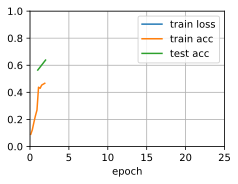

In [0]:
# Finetune a pretrained alexnet

# load a pretrained alexnet
pretrained_alexnet  = gluon.model_zoo.vision.alexnet(pretrained=True) ## AlexNet ##

# create an alexnet with 21 outputs, put pretrained weights in and initialize the output layer. Also set the learn rate for the output layer 10x higher
finetune_net = gluon.model_zoo.vision.alexnet(classes=21)
finetune_net.features = pretrained_alexnet.features
finetune_net.output.initialize(init.Xavier())
finetune_net.output.collect_params().setattr('lr_mult', 10)

finetune_net.output
train_fine_tuning(finetune_net, 0.01, num_epochs=25)